In [364]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import salem
from cdo import *
from pathlib import Path
from os import path, remove
import sys
import geopandas as gpd
from cftime import Datetime360Day
cdo = Cdo()
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *
from netCDF4 import Dataset

In [3]:
shp = (gpd
       .read_file('/home/abhi/Documents/data/shapefiles/India_climatic_correct/India_climatic_correct.shp'))

shp = shp.loc[~shp.Region.str.startswith('Him'), :]

In [160]:
def getFile(model, var, metric, seas=None):
    if metric in ['wetdayprecip_1mm', 'wetdayfreq_1mm'] or re.match(r'pd_[0-9]+mm', metric):
        metric_name, thresh = metric.split('_')
        return f"../data/{model}/{var}/{metric_name}/1971-2000_rm_ll25_{seas}_{metric_name}_{thresh}.nc"
    
    elif re.match(re.compile(r"[A|B|N]_[abs|anam]+"), metric) and var == 'precip':
        return f"../data/{model}/precip/ABN/1971-2000_rm_ll25_{metric}.nc"
    
    else:
        return f"../data/{model}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc"


In [158]:
re.match(re.compile(r"[A|B|N]_[abs|anam]+"), "A_abs")

<_sre.SRE_Match object; span=(0, 5), match='A_abs'>

In [68]:
!ncview {getFile('IMD', 'precip', 'pd_10mm', 'JJAS')}

Ncview 2.1.6 David W. Pierce  29 Oct 2015
http://meteora.ucsd.edu:80/~pierce/ncview_home_page.html
Copyright (C) 1993 through 2015, David W. Pierce
Ncview comes with ABSOLUTELY NO WARRANTY; for details type `ncview -w'.
This is free software licensed under the Gnu General Public License version 3; type `ncview -c' for redistribution details.

calculating min and maxes for precipitation_days_index_per_time_period.
XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 964 requests (964 known processed) with 0 events remaining.


In [64]:
getFile('IMD', 'precip', 'wetdayprecip_1mm', 'Annual')

'../data/IMD/precip/wetdayprecip/1971-2000_rm_ll25_Annual_wetdayprecip_1mm.nc'

In [84]:
getCompareFile = lambda m1, m2, var, metric, seas: \
f'/home/abhi/Documents/mygit/GCM_RCM/data/{m1}_{m2}/{var}/{metric}/1971-2000_rm_ll25_{seas}_{metric}.nc'

In [5]:
def getvarname(model, var):
    if model in ['IMD', 'PRECIS']:
        return {'precip': 'precip',
               'tmean': 'tmean',
               'tmax': 'tmax',
               'tmin': 'tmin'}[var]
    
    elif model == 'HADGEM2-ES':
        return {'precip': 'pr',
               'tmean': 'tas',
               'tmax': 'tasmax',
               'tmin': 'tasmin'}[var]

def gettimename(model, var):
    if ((model in ['IMD', 'HADGEM2-ES'])
        or
        (model == 'PRECIS') and (var == 'tmean')):
        
        return 'time'
    
    elif model == 'PRECIS':
        return 't'

In [6]:
models = ['IMD', 'PRECIS', 'HADGEM2-ES']

### Comparison plots for (IMD vs PRECIS vs HADGEM2-ES)

In [ ]:
levels = {}

/home/abhi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater


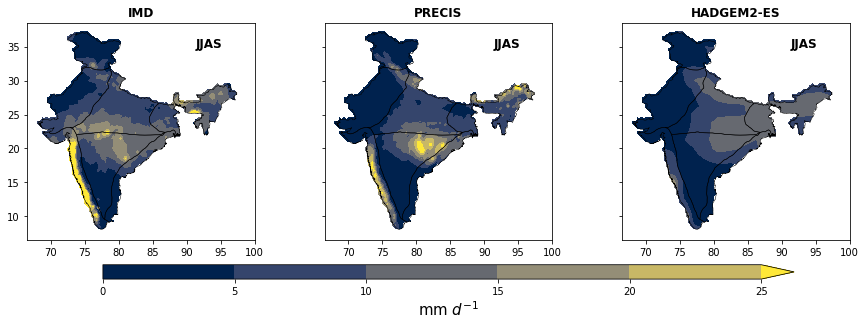

In [940]:
metric = 'A_abs'
seas = 'JJAS'
var = 'precip'
levels = np.arange(0, 30, 5)
# levels = np.arange(0, 26, 2)
# levels = np.arange(0, 5.5, 0.5)
# levels = [1, 2, 5] + list(range(10, 110, 10))
# levels = np.arange(0, 450, 50)
# levels = np.arange(0, 100, 10)
# levels = np.arange(0, 10, 2)
# levels = np.arange(0, 32, 4)
# levels = np.arange(0, 5, 0.5)
# levels = np.arange(-180, 200, 20)
# levels = np.arange(0, 11, 1)
# levels = np.arange(36, 48, 1)
addmeantext = False
savefig=True
unittext = "mm $d^{-1}$"
# unittext = "$^\circ C$"
# unittext = "% days"
# unittext = "%"
cmap = 'cividis'
# cmap = 'plasma'
# cmap = 'RdBu'
# cmap = 'YlOrRd'
# cmap = 'viridis'


normalize=False
addWestCoastMeanVal = False
addfcorVal = False


fig, axn = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(16, 4),
                       )
fig.subplots_adjust(hspace=0, wspace=0)

for ax, model in zip(axn, models):
    if re.match(re.compile(r'r[0-9]+p'), metric):
        var_name = 'var1'
        time_name = 'time'
        
    elif re.match(r'[[cdd]+|[cwd]+]', metric):
        metric_name = metric.split('_')[0]
        var_name = f'number_of_{metric_name}_periods_with_more_than_5days_per_time_period'
        time_name = 'time'
        
    elif re.match(r'pd_[0-9]+mm', metric):
        var_name = 'precipitation_days_index_per_time_period'
        time_name = 'time'
    else:
        var_name = getvarname(model, var)
        time_name = gettimename(model, var)
    
    if 'tail' in metric:
        metric_type = metric.replace('tail', '')
        nc90 = getFile(model, var, f'90p{metric_type}', seas)
        nc99 = getFile(model, var, f'99p{metric_type}', seas)
        
        if normalize:
            if 'wet' in metric:
                meanfile = getFile(model, var, 'wetdayprecip_1mm', seas)
            else:
                meanfile = getFile(model, var, 'timmean', seas)

            ds = xr.open_dataset(cdo.div(input=f"-sub {nc99} {nc90} {meanfile}",
                                            returnCDF=True))[var_name].mean(dim=time_name)
            
        else:
            ds = xr.open_dataset(cdo.sub(input=f"{nc99} {nc90}",
                                            returnCDF=True))[var_name].mean(dim=time_name)
    else:
        try:
            ds = xr.open_dataset(getFile(model, var, metric, seas))[var_name].mean(dim=time_name)
        except Exception:
            ds = xr.open_dataset(getFile(model, var, metric, seas))[var_name]
            
            
    if model == 'HADGEM2-ES':
        north_ds1 = ds.salem.roi(shape=shp.loc[shp.Region.str.startswith('Northern')])
        north_ds2 = ds.loc[(ds.lat > 34)]
        arr = north_ds2.values
        arr[arr > 40] = float(north_ds1.where(north_ds1 < 40).mean().values)
        north_ds2.values = arr
        ds.loc[(ds.lat > 34)] = north_ds2
        
    if model == 'IMD' and addfcorVal:
        imd_nc = "/tmp/IMD_file.nc"
        ds.to_netcdf(imd_nc)
        imd_mask = "/tmp/IMD_mask.nc"
        cdo.lec('-9999', input=imd_nc, 
                         output=imd_mask)
        
        imd_da = ds
        imd_var_name = var_name
        
    
    plot = ds.plot.contourf(ax=ax, levels=levels, extend='max', cmap=cmap)
    plot.colorbar.remove()
    
    shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    
    ax.text(0.8, 0.9, 
           seas,
            fontsize=12,
            fontweight='bold',
            horizontalalignment='center',
            verticalalignment='center',
           transform = ax.transAxes)
    
    if addmeantext:
        meanval = round(float(ds.mean().values), 2)
        
        ax.text(0.8, 0.1, 
               f"{meanval} "+ unittext,
                fontsize=8,
                fontweight='bold',
                horizontalalignment='center',
                verticalalignment='center',
               transform = ax.transAxes)
        
    if addWestCoastMeanVal:
        wcMeanVal = round(
                         float(ds
                               .salem
                               .roi(shape=shp.loc[shp.Region == 'West Coast']).mean()), 2)
        
        ax.text(0.15, 0.1, 
       f"{wcMeanVal} "+ unittext,
        fontsize=8,
        fontweight='bold',
        horizontalalignment='center',
        verticalalignment='center',
       transform = ax.transAxes)
        
    if addfcorVal and model is not 'IMD':
        mod_nc = f"/tmp/{model}_file.nc"
        ds.to_netcdf(mod_nc)
        
        mod_arr = ds.values.flatten()
        mod_arr = mod_arr[~np.isnan(mod_arr)]
        
        imd_arr = imd_da.values.flatten()
        imd_arr = imd_arr[~np.isnan(imd_arr)]
        
        if mod_arr.size > imd_arr.size:
            
        
            mod_masked = f"/tmp/{model}_masked.nc"
            os.system(f"rm {mod_masked}")

        
            cdo.mul(input=f"{mod_nc} {imd_mask}", 
                   output=mod_masked)
        
        
        try:
            mod_da = xr.open_dataset(mod_masked)[var_name]
            mod_arr = mod_da.values.flatten()
            
        except Exception:
            mod_da = Dataset(mod_masked)
            mod_arr = np.array(mod_da.variables[var_name])
            mod_da = xr.open_dataset(xr.backends.NetCDF4DataStore(mod_da))
        
        


        mod_arr = mod_arr[~np.isnan(mod_arr)]

        fcor = round(np.corrcoef(imd_arr, 
                     mod_arr)[0][1], 2)

        ax.text(0.65, 0.1, 
       f"fcor: {fcor}",
        fontsize=8,
        fontweight='bold',
        horizontalalignment='center',
        verticalalignment='center',
       transform = ax.transAxes)
        
        

        
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(model, fontweight='bold')
    
    
    
cbar_ax = fig.add_axes([0.2, -0.01, 0.6, 0.05])
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal')
cbar.set_label(unittext, fontsize=15)

if savefig:
    plt_name = '_'.join(models) + "_" + seas
    outdir = f'../plots/compare/{var}/{metric}'
    
    os.system(f'mkdir -p {outdir}')
    fig.savefig(f"{outdir}/{plt_name}.png", dpi=400,
               bbox_inches='tight')

In [864]:
fcor_df.loc[((fcor_df.model == 'PRECIS')&
             (fcor_df['var'] == 'precip'))]

,model,var,metric,region,seas,value
0,PRECIS,precip,timmean,Northern,Annual,0.407745
1,PRECIS,precip,timstd,Northern,Annual,-0.293384
2,PRECIS,precip,cdd_1_5,Northern,Annual,0.079606
3,PRECIS,precip,cwd_1_5,Northern,Annual,0.274656
4,PRECIS,precip,A_abs,Northern,Annual,0.730113
5,PRECIS,precip,B_abs,Northern,Annual,0.368058
6,PRECIS,precip,r90p,Northern,Annual,0.306610
7,PRECIS,precip,pd_1mm,Northern,Annual,0.373067
8,PRECIS,precip,pd_5mm,Northern,Annual,0.473536
9,PRECIS,precip,pd_10mm,Northern,Annual,0.425306


In [907]:
def sel_fcordf(model, var, metric, region, seas):
    cond_dict = {}
    for col in ['model', 'var', 'metric',
               'region', 'seas']:
        cond_dict[col] = fcor_df[col] == eval(col)
        
        
    all_cond = ' & '.join([f"cond_dict['{col}']" for col in cond_dict.keys()])
    
    return float(fcor_df.loc[eval(all_cond)]['value'])

In [880]:
model, var, metric, region, seas = 'PRECIS', 'precip', 'timmean', 'India', 'Annual'

In [897]:
cond_dict = {}
for col in ['model', 'var', 'metric',
           'region', 'seas']:
    cond_dict[col] =fcor_df[col] == eval(col)


all_cond = ' & '.join([f"cond_dict['{col}']" for col in cond_dict.keys()])

fcor_df.loc[eval(all_cond)]

,model,var,metric,region,seas,value
184,PRECIS,precip,timmean,India,Annual,0.672077


In [890]:
all_cond

"cond_dict['model'] & cond_dict['var'] & cond_dict['metric'] & cond_dict['region'] & cond_dict['seas']"

In [879]:
model = 'PRECIS'
col = 'model'
fcor_df.loc[fcor_df[col] == eval(col)].head()

,model,var,metric,region,seas,value
0,PRECIS,precip,timmean,Northern,Annual,0.407745
1,PRECIS,precip,timstd,Northern,Annual,-0.293384
2,PRECIS,precip,cdd_1_5,Northern,Annual,0.079606
3,PRECIS,precip,cwd_1_5,Northern,Annual,0.274656
4,PRECIS,precip,A_abs,Northern,Annual,0.730113


In [918]:
for model in ['PRECIS', 'HADGEM2-ES']:
    print(model, sel_fcordf(model, 'precip', 'B_abs', 
                     'Core Monsoon', 'Annual'))

PRECIS 0.8519501385013457
HADGEM2-ES 0.48228712192336454


In [606]:
f1 = getFile('IMD', 'precip', 'A_abs', 'JJAS')
f2 = getFile('PRECIS', 'precip', 'A_abs', 'JJAS')


In [756]:
def getActualVarName(model, var, metric):
    if re.match(re.compile(r'r[0-9]+p'), metric):
            var_name = 'var1'
            time_name = 'time'

    elif re.match(r'[[cdd]+|[cwd]+]', metric):
        metric_name = metric.split('_')[0]
        var_name = f'number_of_{metric_name}_periods_with_more_than_5days_per_time_period'
        time_name = 'time'

    elif re.match(r'pd_[0-9]+mm', metric):
        var_name = 'precipitation_days_index_per_time_period'
        time_name = 'time'
    else:
        var_name = getvarname(model, var)
        time_name = gettimename(model, var)

    
    return var_name


In [609]:
arr1 = xr.open_dataset(f1)#.salem.roi(shape=shp.loc[shp.Region == 'West Coast'])
arr1 = arr1['precip'].values.flatten()
arr1 = arr1[~np.isnan(arr1)]

arr2 = xr.open_dataset(f2)#.salem.roi(shape=shp.loc[shp.Region == 'West Coast'])
arr2 = arr2['precip'].values.flatten()
arr2 = arr2[~np.isnan(arr2)]

In [604]:
arr1.shape

(4964,)

In [612]:
def subset_region(ds, region):
    if region == 'India':
        return ds
    elif region == 'Core Monsoon':
        return sellonlatbox(ds, [73, 82, 18, 28])
    else:
        return ds.salem.roi(shape=shp.loc[shp.Region == region])

In [754]:
def getCorr(model, var, metric, region='India', seas=None, var_name=None):
    arr = {}
    for m in ['IMD', model]:
        arr[m] = xr.open_dataset(getFile(m, var, metric, seas))
        arr[m] = subset_region(arr[m], region)
        if var_name is None:
            variable = getActualVarName(m, var, metric)
        else:
            variable = var_name
            
        arr[m] = arr[m][variable].values
        
        if m == 'IMD':
            arr_mask = arr['IMD'].copy()
            arr_mask[~np.isnan(arr_mask)] = 0
            
        elif m == model:
            arr[m] = arr[m] + arr_mask
            
        arr[m] = arr[m].flatten()
        arr[m] = arr[m][~np.isnan(arr[m])]
    
    
    return np.corrcoef(arr['IMD'], arr[model])[0][1]

In [624]:
getvarname('HADGEM2-ES', 'precip')

'pr'

In [686]:
metric_name = 'cdd_1_5'

In [687]:
getFile('IMD', 'precip', metric_name, 'JJAS')

'../data/IMD/precip/cdd_1_5/1971-2000_rm_ll25_JJAS_cdd_1_5.nc'

In [690]:
var_name = f'number_of_cdd_periods_with_more_than_5days_per_time_period'

In [759]:
getCorr('PRECIS', 'precip', 'cdd_1_5', 'India', seas='JJAS')

0.7151498588837667

In [728]:
regionIndex_new = pd.Index(['Northern',
                             'North East',
                             'North West',
                             'Central',
                             'Inner Peninsular',
                             'West Coast',
                             'East Coast',
                             'Core Monsoon',
                             'India'], name='region')

In [777]:
fcor_lst = []

In [770]:
varIndex = pd.Index(['precip', 'tmax', 'tmin', 'tmean'], name='var_name')

In [771]:
pd_threshIndex = pd.Index([f'pd_{thresh}mm' for thresh in [1, 5, 10, 20, 30, 50, 100, 200]],
                         name='pd_thresh')

In [767]:
metric_lst = ['timmean', 'timstd', 
                               'cdd_1_5', 'cwd_1_5',
                              'A_abs', 'B_abs', 'r90p', 
              
             ] + list(pd_threshIndex) + [f'{thresh}p' for thresh in [5, 10, 25, 50, 75, 90, 95, 99]]

In [768]:
metric_lst

['timmean',
 'timstd',
 'cdd_1_5',
 'cwd_1_5',
 'A_abs',
 'B_abs',
 'r90p',
 'pd_1mm',
 'pd_5mm',
 'pd_10mm',
 'pd_20mm',
 'pd_30mm',
 'pd_50mm',
 'pd_100mm',
 'pd_200mm',
 '5p',
 '10p',
 '25p',
 '50p',
 '75p',
 '90p',
 '95p',
 '99p']

In [779]:
seasIndex = pd.Index(['Annual', 'JJAS', 'ON', 'DJF', 'MAM'], name='seas')

In [780]:
seasIndex

Index(['Annual', 'JJAS', 'ON', 'DJF', 'MAM'], dtype='object', name='seas')

In [781]:
%%time
for model in models[1:]:
    for var in varIndex:
        for seas in seasIndex:
            for region in regionIndex_new:
                for metric in metric_lst:

                    entry_args = [model, var, metric, region, seas]
                    try:
                        val = getCorr(*entry_args)
                    except Exception:
                        val = np.nan

                    entry = entry_args + [val]

                    fcor_lst.append(entry)


/home/abhi/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/abhi/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


CPU times: user 11min 20s, sys: 0 ns, total: 11min 20s
Wall time: 11min 21s


In [853]:
perc_df = fcor_df.loc[fcor_df.metric.str.match(r'9[0-9]+p')]

In [788]:
fcor_df = pd.DataFrame(fcor_lst, columns=['model', 'var', 'metric', 'region', 'seas', 'value'])

In [845]:
df1 = fcor_df.loc[fcor_df.metric == 'timstd']
df1 = df1.loc[df1.region == 'India']

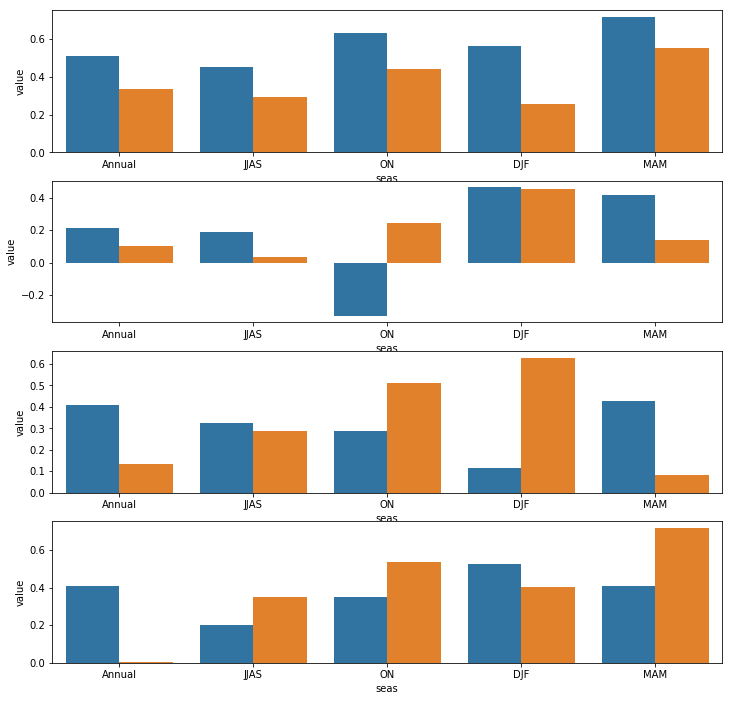

In [846]:
fig, axn = plt.subplots(4, 1, figsize=(12, 12), )

for ax, var in zip(axn, list(varIndex)):
    sns.barplot(data=df1.loc[df1['var'] == var], x='seas', y='value', hue='model', ax=ax)
    ax.legend().remove()

In [822]:
ax.legend().remove()

In [811]:
def plot_func(s1,s2,s3, **kwargs):
    df = pd.concat([s1, s2, s3])
    
    sns.barplot(data=df, x='seas', y='value', hue='model')

In [807]:
df1.head()

,model,var,metric,region,seas,value
184,PRECIS,precip,timmean,India,Annual,0.672077
391,PRECIS,precip,timmean,India,JJAS,0.717956
598,PRECIS,precip,timmean,India,ON,0.488783
805,PRECIS,precip,timmean,India,DJF,0.665906
1012,PRECIS,precip,timmean,India,MAM,0.700631


ValueError: Could not interpret input 'seas'

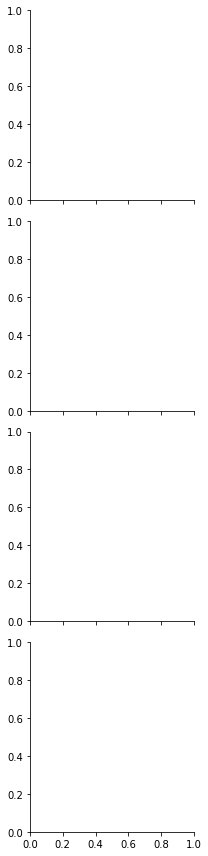

In [812]:
g = sns.FacetGrid(data=df1, row='var')
g.map(plot_func, 'model', 'metric', 'seas')

In [795]:
df1.

,model,var,metric,region,seas,value
184,PRECIS,precip,timmean,India,Annual,0.672077
391,PRECIS,precip,timmean,India,JJAS,0.717956
598,PRECIS,precip,timmean,India,ON,0.488783
805,PRECIS,precip,timmean,India,DJF,0.665906
1012,PRECIS,precip,timmean,India,MAM,0.700631
1219,PRECIS,tmax,timmean,India,Annual,0.883999
1426,PRECIS,tmax,timmean,India,JJAS,0.745280
1633,PRECIS,tmax,timmean,India,ON,0.876751
1840,PRECIS,tmax,timmean,India,DJF,0.890312
2047,PRECIS,tmax,timmean,India,MAM,0.868945


In [736]:
getCorr('HADGEM2-ES', 'precip', '90p', 'India', seas='Annual')

ValueError: operands could not be broadcast together with shapes (4964,) (4949,) 

In [610]:
np.corrcoef(arr1, arr2)[0][1]

0.7098186302561784

In [569]:
var_name = 'precipitation_days_index_per_time_period'

In [574]:
pr = cdo.fldcor(input=f"{f1} {f2}", returnArray=var_name)

In [575]:
pr

masked_array(data=[[[0.49714172]]],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [553]:
pr

masked_array(data=[[--]],
             mask=[[ True]],
       fill_value=nan,
            dtype=float32)

In [474]:
sellonlatbox(ds, [73, 82, 18, 28]).mean()

<xarray.DataArray 'precipitation_days_index_per_time_period' ()>
array(6.360543, dtype=float32)

In [433]:
mod_arr.shape

(4949,)

In [413]:
xr.open_dataset(xr.backends.NetCDF4DataStore(mod_da)).pr

<xarray.DataArray 'pr' (lat: 129, lon: 135)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5

In [360]:
for model in models:
    for fname in ['file', 'masked', 'mask']:
        os.system(f'rm /tmp/{model}_{fname}.nc')

In [395]:
pr = Dataset(mod_masked).variables['pr']

In [402]:
mod_arr = np.array(pr).flatten()
mod_arr = mod_arr[~np.isnan(mod_arr)]

In [414]:
np.cov(imd_arr, mod_arr)

array([[180.81032049,  69.57317134],
       [ 69.57317134,  87.04447189]])

In [404]:
mod_arr.shape

(4949,)

In [385]:
xr.open_dataset(cdo.fldcor(input=f"{imd_nc} {mod_masked}")).precip

<xarray.DataArray 'precip' (lat: 1, lon: 1)>
array([[nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0

In [294]:
north_ds1 = ds.salem.roi(shape=shp.loc[shp.Region.str.startswith('Northern')])
north_ds2 = ds.loc[(ds.lat > 34)]
arr = north_ds2.values
arr[arr > 40] = float(north_ds.where(north_ds < 40).mean().values)
north_ds2.values = arr
ds.loc[(ds.lat > 34)] = north_ds2

In [303]:
arr = ds.values.flatten()

In [305]:
arr = arr[~np.isnan(arr)]

In [310]:
np.corrcoef(arr, arr)[0][1]

0.9999999999999998

In [296]:
north_ds1.mean()

<xarray.DataArray 'tasmax' ()>
array(13.992087, dtype=float32)
Coordinates:
    height   float64 1.5

In [147]:
df = ds.salem.roi(shape=shp.loc[shp.Region == 'West Coast']).to_dataframe().reset_index()
                              

In [136]:
float(ds.salem.roi(shape=shp.loc[shp.Region == 'West Coast']).mean())

5.389538288116455

In [27]:
metric

'r90p'

In [28]:
re.match(re.compile(r'r[0-9]+p'), metric)

<_sre.SRE_Match object; span=(0, 4), match='r90p'>

In [25]:
var_name

'precip'

In [311]:
ds.max()

<xarray.DataArray 'pr' ()>
array(81.84259)

In [264]:
ds90 = getFile('IMD', 'precip', '90pwet', 'Annual')
ds99 = getFile('IMD', 'precip', '99pwet', 'Annual')

ds_tail = cdo.sub(input=f"{ds99} {ds90}", 
                 returnCDF=True)

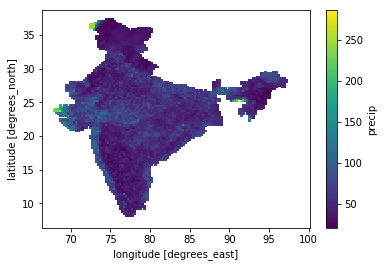

In [267]:
xr.open_dataset(ds_tail).precip.mean('time').plot()

### BIAS, RMSE and CC plots

In [85]:
metric = 'RMSE'
seas = 'JJAS'
var = 'tmax'
levels = np.arange(-5, 6, 1)
addmeantext = True
savefig=False
unittext = "$mm^{-1} d$"
# unittext = "$^\circ C$"
# unittext = ''
cmap = 'seismic_r'


def corrplot(metric, seas, var, 
             levels=np.arange(-1, 1.1, 0.1), addmeantext=False, 
             savefig=False, unittext='', cmap='seismic_r'):
    
    
    fig, axn = plt.subplots(ncols=2, sharex=True, sharey=True,
                           figsize=(10, 4),
                           )

    for ax, model in zip(axn, models[1:]):
        var_name = getvarname(model, var)
        time_name = gettimename(model, var)

        ds = xr.open_dataset(getCompareFile(model, 'IMD', var, metric, seas))[var_name].mean(dim=time_name)

        plot = ds.plot.contourf(ax=ax, levels=levels, extend='both', cmap=cmap)
        plot.colorbar.remove()

        shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

        ax.text(0.8, 0.9, 
               seas,
                fontsize=12,
                fontweight='bold',
                horizontalalignment='center',
                verticalalignment='center',
               transform = ax.transAxes)

        if addmeantext:
            meanval = round(float(ds.mean().values), 2)

            ax.text(0.8, 0.1, 
                   f"{meanval} "+ unittext,
                    fontsize=8,
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                   transform = ax.transAxes)

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(model, fontweight='bold')

    fig.subplots_adjust(hspace=0, wspace=0.1)


    cbar_ax = fig.add_axes([0.46, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(plot, cax=cbar_ax)
    cbar.set_label(unittext, fontsize=10)
    cbar_ax.yaxis.set_label_position('left')



    if savefig:
        plt_name = '_'.join(models[1:]) + "_IMD_" + seas
        outdir = f'../plots/compare/{var}/{metric}'

        os.system(f'mkdir -p {outdir}')
        fig.savefig(f"{outdir}/{plt_name}.png", dpi=400,
                   bbox_inches='tight')
        plt.close(fig)

In [250]:
for seas in ['Annual', 'JJAS', 'ON', 'DJF', 'MAM']:
    for var in ['precip', 'tmax', 'tmin', 'tmean']:
        corrplot('timcor', seas, var, savefig=True)

In [930]:
metric = 'RMSE'
seas = 'JJAS'
var = 'precip'
# levels = np.arange(-10, 12, 2)
levels = np.arange(0, 22, 2)
addmeantext = False
savefig=True
unittext = "mm $d^{-1}$"
# unittext = "$^\circ C$"
# unittext = '$^\circ C$'
# cmap = 'seismic'
# cmap = 'BrBG'
# cmap = 'CMRmap'
cmap = 'rainbow'

In [931]:

fig, axn = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 4),
                       )

for ax, model in zip(axn, models[1:]):
    var_name = getvarname(model, var)
    time_name = gettimename(model, var)

    ds = xr.open_dataset(getCompareFile(model, 'IMD', var, metric, seas))[var_name].mean(dim=time_name)

    plot = ds.plot.contourf(ax=ax, levels=levels, extend='max', cmap=cmap)

    plot.colorbar.remove()

    shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

    ax.text(0.8, 0.9, 
           seas,
            fontsize=12,
            fontweight='bold',
            horizontalalignment='center',
            verticalalignment='center',
           transform = ax.transAxes)

    if addmeantext:
        meanval = round(float(ds.mean().values), 2)

        ax.text(0.8, 0.1, 
               f"{meanval} "+ unittext,
                fontsize=8,
                fontweight='bold',
                horizontalalignment='center',
                verticalalignment='center',
               transform = ax.transAxes)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(model, fontweight='bold')

fig.subplots_adjust(hspace=0, wspace=0.1)


cbar_ax = fig.add_axes([0.46, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plot, cax=cbar_ax)
cbar.set_label(unittext, fontsize=10)
cbar_ax.yaxis.set_label_position('left')



if savefig:
    plt_name = '_'.join(models[1:]) + "_IMD_" + seas
    outdir = f'../plots/compare/{var}/{metric}'

    os.system(f'mkdir -p {outdir}')
    fig.savefig(f"{outdir}/{plt_name}.png", dpi=400,
               bbox_inches='tight')
    plt.close(fig)

In [7]:
ds = xr.open_dataset('/home/abhi/Documents/data/OBSERVATION/IMD/precip/imdCAL.nc',
                    chunks={'time': 360})

In [20]:
shp

,Region,geometry
0,Northern,"POLYGON ((74.69647216796902 37.09747314453151,..."
1,North East,"POLYGON ((96.07592773437526 29.45227050781277,..."
2,North West,"POLYGON ((78.66308593750018 32.09088134765651,..."
3,Central,"POLYGON ((79.07147216796913 31.44647216796909,..."
4,Inner Peninsular,"POLYGON ((77.9238064266911 22.36504369950693, ..."
5,West Coast,"POLYGON ((72.81860684424524 23.08328317338179,..."
6,East Coast,"POLYGON ((88.23954612524412 22.62552936501093,..."


In [16]:
shp.loc[shp.Region == 'Central', 'geometry']

3    POLYGON ((79.07147216796913 31.44647216796909,...
Name: geometry, dtype: object

CPU times: user 1.87 s, sys: 384 ms, total: 2.26 s
Wall time: 1.14 s


(array([1480079.,  357210.,  175105.,   94103.,   53511.,   32113.,
          20483.,   13170.,    8985.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 <a list of 9 Patch objects>)

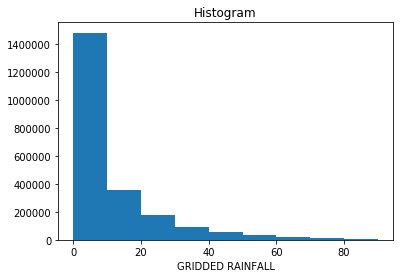

In [21]:
%%time
selseas(ds.salem.roi(shape=shp.loc[shp.Region == 'North East', :]), 
                     'JJAS').precip.plot.hist(bins=np.arange(0, 100, 10))

In [190]:
obs_f = getFile('IMD', 'precip', 'A_abs', 'JJAS')
mod_f = lambda model: getFile(model, 'precip', 'A_abs', 'JJAS')

ftest = cdo.fldcor(input=f"{obs_f} {obs_f}",
                   returnCDF=True)

In [194]:
xr.open_dataset(ftest).precip

<xarray.DataArray 'precip' (lat: 1, lon: 1)>
array([[nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0

In [452]:
ds = xr.open_dataset(
    getCompareFile('PRECIS', 'IMD', 'precip', 'RMSE', 'JJAS'))

<xarray.Dataset>
Dimensions:  (bnds: 2, lat: 129, lon: 135, t: 1)
Coordinates:
  * t        (t) object 1986-02-01 00:00:00
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
Dimensions without coordinates: bnds
Data variables:
    t_bnds   (t, bnds) float64 ...
    precip   (t, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Jan 14 11:42:52 2019: cdo -O sqrt -timmean -sqr -sub -y...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

In [454]:
getCompareFile('PRECIS', 'IMD', 'precip', 'RMSE', 'JJAS')

'/home/abhi/Documents/mygit/GCM_RCM/data/PRECIS_IMD/precip/RMSE/1971-2000_rm_ll25_JJAS_RMSE.nc'

In [1015]:
precip_fcor = fcor_df.loc[(fcor_df['var'] == 'precip') &
           (fcor_df['seas'] == 'JJAS') &
           (fcor_df['region'] != 'Northern') &
           (~fcor_df.metric.str.match(r'[5p|10p|25p|50p|75p]'))].drop(['var','seas'],
                                                                                axis=1)

In [950]:
re.match(re.compile(r'[5|10|25|50|75]+p'), '25p')

<_sre.SRE_Match object; span=(0, 3), match='25p'>

In [970]:
precip_fcor.set_index(['metric', 'region']).sort_index(0).sort_index(1).to_csv("../csv/Analysis-6/precip_fcor.csv")

In [973]:
precip_fcor = precip_fcor.set_index(['metric', 'region']).sort_index(0).sort_index(1)

In [1014]:
fcor_df.loc[fcor_df.metric == 'pd_30mm']

,model,var,metric,region,seas,value
11,PRECIS,precip,pd_30mm,Northern,Annual,0.304504
34,PRECIS,precip,pd_30mm,North East,Annual,0.342323
57,PRECIS,precip,pd_30mm,North West,Annual,0.345450
80,PRECIS,precip,pd_30mm,Central,Annual,0.361272
103,PRECIS,precip,pd_30mm,Inner Peninsular,Annual,0.741200
126,PRECIS,precip,pd_30mm,West Coast,Annual,0.794656
149,PRECIS,precip,pd_30mm,East Coast,Annual,0.562070
172,PRECIS,precip,pd_30mm,Core Monsoon,Annual,0.593672
195,PRECIS,precip,pd_30mm,India,Annual,0.508811
218,PRECIS,precip,pd_30mm,Northern,JJAS,0.407948


In [988]:
precip_fcor_f = pd.pivot_table(precip_fcor, values='value', index=['metric', 'model'], columns=['region'])

In [983]:
region_order = ['Central', 'North West', 'North East', 
                'West Coast', 'East Coast', 'Core Monsoon',
               'India']

In [989]:
precip_fcor_f = precip_fcor_f[region_order]

In [1046]:
precip_fcor = fcor_df.loc[(fcor_df['var'] == 'precip') &
           (fcor_df['seas'] == 'JJAS') &
           (fcor_df['region'] != 'Northern') &
           (~fcor_df.metric.str.match(r'[5p|10p|25p|50p|75p]') &
           (~fcor_df.metric.str.match(r'pd')))].drop(['var','seas'],
                                                                                axis=1)
precip_fcor_f = pd.pivot_table(precip_fcor, values='value', index=['metric', 'model'], columns=['region'])
precip_fcor_f = precip_fcor_f[region_order]
# precip_fcor_f.to_csv("../csv/Analysis-6/precip_fcor_f.csv")

In [1045]:
precip_fcor = fcor_df.loc[(fcor_df['var'] == 'precip') &
           (fcor_df['seas'] == 'Annual') &
           (fcor_df['region'] != 'Northern') &
           (fcor_df.metric.str.match(r]))].drop(['var','seas'],

                                                                        axis=1)
precip_fcor_f = pd.pivot_table(precip_fcor, values='value', index=['metric', 'model'], columns=['region'])
precip_fcor_f = precip_fcor_f[region_order]

SyntaxError: invalid syntax (<ipython-input-1045-837c82060981>, line 4)

In [1043]:
precip_fcor_f.applymap(lambda x: round(x, 2)).to_csv("../csv/Analysis-6/precip_fcor_f.csv")

In [1047]:
precip_fcor_f.applymap(lambda x: round(x, 2))

region              Central  North West  North East  West Coast  East Coast  \
metric  model                                                                 
90p     HADGEM2-ES     0.39        0.63        0.17        0.59        0.85   
        PRECIS         0.52        0.66        0.17        0.82        0.83   
95p     HADGEM2-ES     0.35        0.60        0.15        0.56        0.87   
        PRECIS         0.28        0.57        0.17        0.78        0.81   
99p     HADGEM2-ES     0.09        0.49        0.16        0.56        0.86   
        PRECIS        -0.02        0.28        0.23        0.71        0.81   
A_abs   HADGEM2-ES    -0.24        0.34       -0.10        0.60        0.91   
        PRECIS         0.45        0.44        0.24        0.82        0.85   
B_abs   HADGEM2-ES     0.79        0.89        0.42        0.73        0.90   
        PRECIS         0.77        0.61        0.33        0.88        0.90   
cdd_1_5 HADGEM2-ES     0.37        0.76        0.32        0.73        0.11   
        PRECIS         0.57        0.83       -0.09        0.59        0.75   
cwd_1_5 HADGEM2-ES     0.29        0.61        0.30        0.47        0.72   
        PRECIS         0.60        0.80        0.60        0.63        0.58   
timmean HADGEM2-ES     0.34        0.67        0.31        0.62        0.88   
        PRECIS         0.62        0.62        0.25        0.83        0.88   
timstd  HADGEM2-ES    -0.03        0.48       -0.02        0.46        0.63   
        PRECIS         0.17        0.49        0.30        0.68        0.64   

region              Core Monsoon  India  
metric  model                            
90p     HADGEM2-ES          0.35   0.55  
        PRECIS              0.69   0.71  
95p     HADGEM2-ES          0.39   0.55  
        PRECIS              0.58   0.62  
99p     HADGEM2-ES          0.36   0.51  
        PRECIS              0.36   0.45  
A_abs   HADGEM2-ES          0.25   0.44  
        PRECIS              0.62   0.71  
B_abs   HADGEM2-ES          0.48   0.74  
        PRECIS              0.85   0.77  
cdd_1_5 HADGEM2-ES          0.51   0.39  
        PRECIS              0.48   0.72  
cwd_1_5 HADGEM2-ES          0.36   0.38  
        PRECIS              0.67   0.69  
timmean HADGEM2-ES          0.30   0.54  
        PRECIS              0.70   0.72  
timstd  HADGEM2-ES          0.17   0.29  
        PRECIS              0.38   0.45